<a href="https://colab.research.google.com/github/suryansh-sharma420/monolingual_hindi_emotion_analysis/blob/main/capstone_monohindi_optimizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

due to class imbalance, we applied oversampling and undersampling together to balance dataset

In [ ]:
import pandas as pd
import re  # regex module
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.utils import resample

# ------------------------- STEP 1: LOADING & RESAMPLING DATA -------------------------

def load_and_resample_data(file_path):
    """
    Load and resample the dataset using hybrid resampling:
    - Downsample the majority class
    - Lightly upsample the minority classes
    """
    try:
        data = pd.read_excel(file_path)
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

    # Remove NaN or empty sentences
    data = data.dropna(subset=['Sentences'])
    data = data[data['Sentences'].str.strip() != '']

    # Convert annotation to int
    data['Annotation'] = data['Annotation'].astype(int)

    print("Original Class Distribution:")
    print(data['Annotation'].value_counts())

    # Separate classes
    class_groups = data.groupby('Annotation')

    # Define resampling strategy
    max_target = 7000  # Target for majority classes after downsampling
    min_target = 5000  # Target for minority classes after upsampling

    resampled_data = []
    for annotation, group in class_groups:
        class_size = len(group)

        if class_size > max_target:
            group_resampled = resample(group, replace=False, n_samples=max_target, random_state=42)
        elif class_size < min_target:
            group_resampled = resample(group, replace=True, n_samples=min_target, random_state=42)
        else:
            group_resampled = group

        resampled_data.append(group_resampled)

    # Combine resampled data
    data_resampled = pd.concat(resampled_data)

    # Shuffle dataset
    data_resampled = data_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

    print("\nResampled Class Distribution:")
    print(data_resampled['Annotation'].value_counts())

    # Save resampled dataset
    data_resampled.to_csv('bhaav_resampled_dataset.csv', index=False)
    print("\nResampled dataset saved as 'bhaav_resampled_dataset.csv'.")

    return data_resampled


# Load and resample dataset
file_path = "Bhaav-Dataset(1).xlsx"
data = load_and_resample_data(file_path)

# ------------------------- STEP 2: PREPROCESSING -------------------------

# Text preprocessing
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s\u0900-\u097F]', '', str(text))  # Keep only letters and Hindi characters
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['Sentences'] = data['Sentences'].apply(preprocess_text)

# ------------------------- STEP 3: TOKENIZATION -------------------------

print("Tokenizing the dataset...")
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

data["Sentences"] = data["Sentences"].fillna("").astype(str)

devices = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoded_data = tokenizer.batch_encode_plus(
    data["Sentences"].tolist(),
    padding=True,
    truncation=True,
    max_length=126,  # Updated padding length
    return_tensors="pt"
)

data['Tokens'] = [tokenizer.convert_ids_to_tokens(ids) for ids in encoded_data["input_ids"]]

# Save tokenized dataset
data.to_csv("tokenized_dataset_resampled.csv", index=False)
print("\nTokenized dataset saved as 'tokenized_dataset_resampled.csv'.")

# ------------------------- STEP 4: GENERATING INDICBERT EMBEDDINGS -------------------------

print("Generating embeddings...")
model = AutoModel.from_pretrained("ai4bharat/indic-bert").to(devices)

def get_embedding(sentence):
    inputs = tokenizer(sentence, padding=True, truncation=True, max_length=126, return_tensors="pt").to(devices)
    with torch.no_grad():  # Disable gradient calculations
        outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].cpu().numpy()

embeddings = np.vstack([get_embedding(sentence) for sentence in data["Sentences"]])

# Save embeddings
np.save("indicbert_embeddings_resampled.npy", embeddings)

print("Sample Embeddings Shape:", embeddings.shape)
print("First Embedding Vector:", embeddings[0])

print("Processing complete!")


Original Class Distribution:
Annotation
4    11697
2     3168
1     2463
3     1512
0     1464
Name: count, dtype: int64

Resampled Class Distribution:
Annotation
4    7000
1    5000
3    5000
2    5000
0    5000
Name: count, dtype: int64

Resampled dataset saved as 'bhaav_resampled_dataset.csv'.
Tokenizing the dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]


Tokenized dataset saved as 'tokenized_dataset_resampled.csv'.
Generating embeddings...


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Sample Embeddings Shape: (27000, 768)
First Embedding Vector: [-1.36403996e-03 -7.53259100e-03  1.38697703e-03  7.67967338e-03
 -9.73788556e-03 -5.69646107e-03  1.42348306e-02  1.78280603e-02
 -1.34226242e-02  9.73149482e-03  5.64839924e-03 -1.49707347e-02
  1.55190341e-02  4.26495122e-03  2.57077673e-03 -1.24585358e-02
 -1.65057695e-03 -3.86795611e-03  1.04512163e-02 -1.37272943e-02
  1.93835162e-02 -1.51680792e-02  2.00584065e-02 -2.16349750e-03
 -6.23676972e-03  3.37544344e-02 -1.43443439e-02  1.70345977e-02
 -2.97889113e-03  9.11824871e-03 -9.39487386e-03  1.18653001e-02
  2.38817427e-02 -5.80338994e-03  3.55173857e-03 -4.57819272e-03
 -2.76667299e-03 -2.87796743e-02 -2.65986994e-02  1.35358199e-02
 -5.51781096e-02  3.65382480e-03 -2.20961007e-03 -2.94225104e-03
  1.45103885e-02 -9.63299884e-04 -1.16289677e-02  6.87753130e-03
  1.01461541e-02  1.32414429e-02 -2.63733382e-04  1.34423021e-02
  1.20442109e-02 -2.01320928e-02 -7.36504421e-03 -2.59464583e-03
 -1.32292155e-02 -1.25856847

just oversampling it(leads to lower accuracy)


In [ ]:
import pandas as pd
import re  # regex module
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.utils import resample

# loading the dataset
print("loading dataset...")
data = pd.read_excel("Bhaav-Dataset(1).xlsx")

# displaying class distribution before rebalancing
print("Class distribution before rebalancing:")
print(data['Annotation'].value_counts())

# another method to count class distribution
import collections
label_counts = collections.Counter(data['Annotation'])
print("Class distribution (collections.Counter):", label_counts)

# preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s\u0900-\u097F]', '', str(text))  # Keep only letters and Hindi characters
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['Sentences'] = data['Sentences'].apply(preprocess_text)
data['Annotation'] = data['Annotation'].astype(int)

# handling class imbalance - oversampling minority classes
majority_class = data['Annotation'].value_counts().idxmax()
minority_classes = data[data['Annotation'] != majority_class]

oversampled_data = resample(minority_classes, replace=True,
                            n_samples=len(data[data['Annotation'] == majority_class]),
                            random_state=42)

data_balanced = pd.concat([data[data['Annotation'] == majority_class], oversampled_data])

# print class distribution after rebalancing
print("\nClass distribution after oversampling:")
print(data_balanced['Annotation'].value_counts())

# save preprocessed balanced dataset
data_balanced.to_csv('preprocessed_dataset_balanced.csv', index=False)
print("Balanced dataset (oversampling) saved.")

# tokenization
print("Tokenizing the dataset...")
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
data_balanced["Sentences"] = data_balanced["Sentences"].fillna("").astype(str)

devices = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoded_data = tokenizer.batch_encode_plus(
    data_balanced["Sentences"].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

data_balanced['Tokens'] = [tokenizer.convert_ids_to_tokens(ids) for ids in encoded_data["input_ids"]]

# print tokens of 5 sentences per annotation
print("\nSample Tokenized Sentences (5 per annotation):")
for annotation in data_balanced['Annotation'].unique():
    print(f"\nAnnotation: {annotation}")
    sample_sentences = data_balanced[data_balanced['Annotation'] == annotation].head(5)
    for _, row in sample_sentences.iterrows():
        print(f"Sentence: {row['Sentences']}\nTokens: {row['Tokens']}\n")

# save tokenized dataset
data_balanced.to_csv("tokenized_dataset_balanced.csv", index=False)

# load IndicBERT
print("Generating embeddings...")
model = AutoModel.from_pretrained("ai4bharat/indic-bert").to(devices)

def get_embedding(sentence):
    inputs = tokenizer(sentence, padding=True, truncation=True, max_length=128, return_tensors="pt").to(devices)
    with torch.no_grad():  # disable gradient calculations
        outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].cpu().numpy()

embeddings = np.vstack([get_embedding(sentence) for sentence in data_balanced["Sentences"]])

# save embeddings
np.save("indicbert_embeddings_balanced.npy", embeddings)

# display sample embeddings
print("Sample Embeddings Shape:", embeddings.shape)
print("First Embedding Vector:", embeddings[0])

print("Processing complete!")

loading dataset...
Class distribution before rebalancing:
Annotation
4    11697
2     3168
1     2463
3     1512
0     1464
Name: count, dtype: int64
Class distribution (collections.Counter): Counter({4: 11697, 2: 3168, 1: 2463, 3: 1512, 0: 1464})

Class distribution after oversampling:
Annotation
4    11697
2     4215
1     3369
3     2068
0     2045
Name: count, dtype: int64
Balanced dataset (oversampling) saved.
Tokenizing the dataset...

Sample Tokenized Sentences (5 per annotation):

Annotation: 4
Sentence: ईदगाह जाने की तैयारियाँ हो रही हैं
Tokens: ['[CLS]', '▁ईद', 'ग', 'ह', '▁जन', '▁क', '▁तय', 'र', 'य', '▁ह', '▁रह', '▁ह', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<p

Loading preprocessed data...
Input size: 768
Number of classes: 5
Total samples: 27000
Training samples: 21600
Testing samples: 5400
Class distribution in training set: [4000 4000 4000 4000 5600]
Class weights: tensor([0.2121, 0.2121, 0.2121, 0.2121, 0.1515])
Using device: cuda
Starting training...
Epoch: 1/50
Train Loss: 1.6217, Train Acc: 24.25%
Val Loss: 1.5856, Val Acc: 24.22%
Learning rate: 0.001000
Epoch: 2/50
Train Loss: 1.5677, Train Acc: 28.08%
Val Loss: 1.5617, Val Acc: 29.07%
Learning rate: 0.001000
Epoch: 3/50
Train Loss: 1.5336, Train Acc: 30.49%
Val Loss: 1.5696, Val Acc: 27.39%
Learning rate: 0.001000
Epoch: 4/50
Train Loss: 1.4984, Train Acc: 32.84%
Val Loss: 1.5024, Val Acc: 33.17%
Learning rate: 0.001000
Epoch: 5/50
Train Loss: 1.4606, Train Acc: 35.33%
Val Loss: 1.4791, Val Acc: 35.37%
Learning rate: 0.001000
Epoch: 6/50
Train Loss: 1.4224, Train Acc: 37.64%
Val Loss: 1.4571, Val Acc: 35.19%
Learning rate: 0.001000
Epoch: 7/50
Train Loss: 1.3853, Train Acc: 39.75%
Va

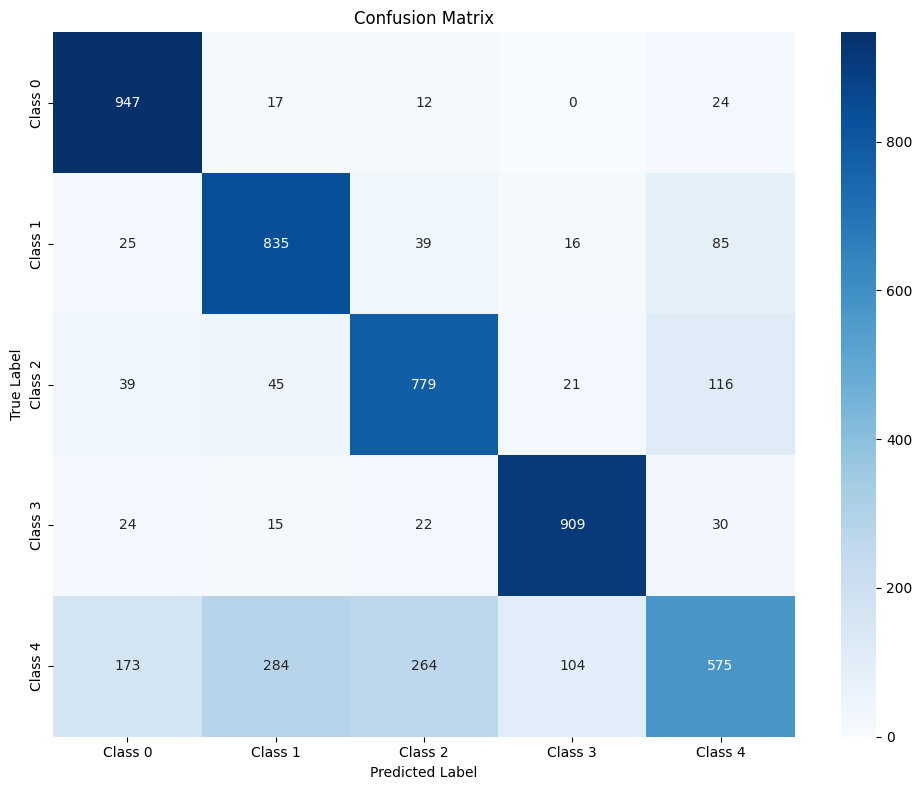

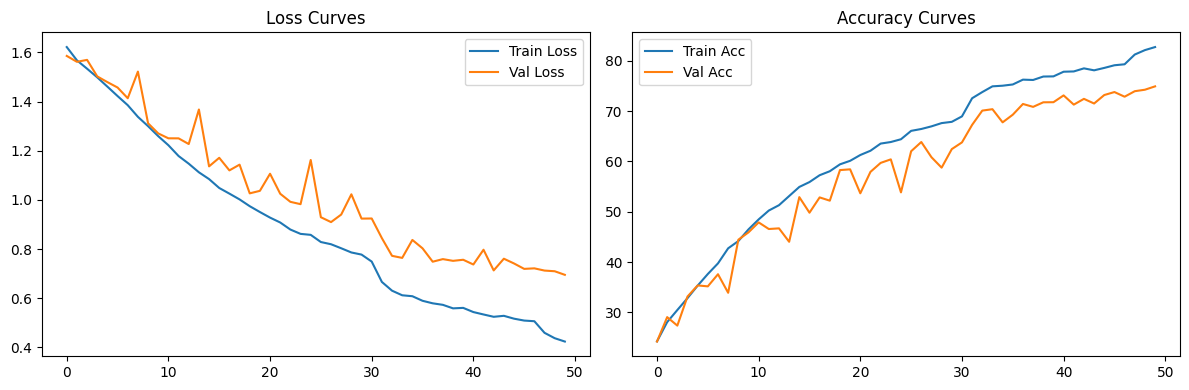

Training completed and model saved!


In [ ]:


# 4. Model Training

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

# Load preprocessed data
print("Loading preprocessed data...")
embeddings = np.load("indicbert_embeddings_resampled.npy")
data = pd.read_csv("tokenized_dataset_resampled.csv")
labels = data["Annotation"].values

# Get input and output dimensions
input_size = embeddings.shape[1]  # Should be 768 for IndicBERT
num_classes = len(np.unique(labels))
print(f"Input size: {input_size}")
print(f"Number of classes: {num_classes}")
print(f"Total samples: {len(labels)}")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Calculate class weights for handling imbalance
class_counts = np.bincount(y_train)
print(f"Class distribution in training set: {class_counts}")
class_weights = torch.FloatTensor(1.0 / class_counts)
class_weights = class_weights / class_weights.sum()
print(f"Class weights: {class_weights}")

# Model definition
class EmotionClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(EmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    return total_loss/len(train_loader), 100.*correct/total

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    return total_loss/len(test_loader), 100.*correct/total, all_preds, all_targets

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = EmotionClassifier(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
early_stopping = EarlyStopping(patience=7)

# Training loop
num_epochs = 50
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("Starting training...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)

    scheduler.step(val_loss)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Epoch: {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.6f}')

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered at epoch", epoch+1)
        break

# Final evaluation
_, _, y_pred, y_true = evaluate(model, test_loader, criterion, device)

# Get class labels for better readability
unique_labels = sorted(np.unique(labels))
target_names = [f"Class {label}" for label in unique_labels]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Save the model
torch.save(model.state_dict(), 'emotion_classifier_final.pth')
print("Training completed and model saved!")

# Optional: Create a function for inference
def predict_emotion(embedding, model, device):
    model.eval()
    embedding_tensor = torch.FloatTensor(embedding).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(embedding_tensor)
        probabilities = F.softmax(output, dim=1)
        _, predicted = output.max(1)

    return predicted.item(), probabilities.cpu().numpy()[0]

# Optional: Test with a few examples if you have the tokenizer and BERT model loaded
# For a complete prediction function, you would need to include:
# - Text preprocessing
# - Tokenization
# - Embedding generation with IndicBERT
# But that would require having the tokenizer and model loaded

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np

# Load the trained model
class EmotionClassifier(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(EmotionClassifier, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 512)
        self.bn1 = torch.nn.BatchNorm1d(512)
        self.dropout1 = torch.nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(512, 256)
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.dropout2 = torch.nn.Dropout(0.3)
        self.fc3 = torch.nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Load model parameters
input_size = 768  # IndicBERT embedding size
num_classes = 5  # Change according to your dataset

model = EmotionClassifier(input_size, num_classes)
model.load_state_dict(torch.load("emotion_classifier_final.pth"))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load IndicBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
bert_model = AutoModel.from_pretrained("ai4bharat/indic-bert").to(device)

# List of Hindi sentences
hindi_sentences = [
    "मुझे बहुत खुशी हो रही है!",
    "आज का दिन बहुत बुरा था।",
    "मुझे गुस्सा आ रहा है!",
    "यह बहुत रोमांचक है!",
    "मैं बहुत दुखी महसूस कर रहा हूँ।",
    "मुझे डर लग रहा है।",
    "यह बहुत अजीब है।",
    "मुझे चिंता हो रही है।",
    "मैं बहुत उत्साहित हूँ!",
    "यह बहुत तनावपूर्ण स्थिति है।"
]

# Function to get embeddings
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

# Predict emotions for the sentences
for sentence in hindi_sentences:
    embedding = get_embedding(sentence)
    embedding_tensor = torch.FloatTensor(embedding).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(embedding_tensor)
        probabilities = F.softmax(output, dim=1)
        _, predicted = output.max(1)

    print(f"Sentence: {sentence}")
    print(f"Predicted Emotion Class: {predicted.item()}")
    print(f"Probabilities: {probabilities.cpu().numpy()[0]}")
    print("-" * 50)


<ipython-input-2-2423f3533489>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("emotion_classifier_final.pth"))


FileNotFoundError: [Errno 2] No such file or directory: 'emotion_classifier_final.pth'

below is the code for sentiment analysis fine tuning in indicbert from github, and i have changed certain things to tune it to my dataset and needs.
if i have to run this i need to change the dataset and reduce annotations to 3, i can do it later if needed.

Using device: cuda
Loading preprocessed data and embeddings...
Data shape: (27000, 3)
Embeddings shape: (27000, 768)
Emotion distribution:
  Joy: 5000
  Anger: 5000
  Suspense: 5000
  Sad: 5000
  Neutral: 7000
Training set: 19507 samples
Validation set: 3443 samples
Test set: 4050 samples
Using FP32 precision
Starting training...


Epoch 1/5 [Val]: 100%|██████████| 108/108 [00:00<00:00, 211.74it/s, loss=1.61]


Epoch 1/5:
  Train - Loss: 1.6030, Accuracy: 0.2510, F1: 0.1290
  Val   - Loss: 1.5991, Accuracy: 0.2594, F1: 0.1068
  F1 scores per emotion:
    Joy: 0.0000
    Anger: 0.0000
    Suspense: 0.0000
    Sad: 0.0000
    Neutral: 0.4119


Epoch 2/5 [Val]: 100%|██████████| 108/108 [00:00<00:00, 261.50it/s, loss=1.61]


Epoch 2/5:
  Train - Loss: 1.5994, Accuracy: 0.2592, F1: 0.1067
  Val   - Loss: 1.5989, Accuracy: 0.2594, F1: 0.1068
  F1 scores per emotion:
    Joy: 0.0000
    Anger: 0.0000
    Suspense: 0.0000
    Sad: 0.0000
    Neutral: 0.4119


Epoch 3/5 [Val]: 100%|██████████| 108/108 [00:00<00:00, 258.79it/s, loss=1.62]


Epoch 3/5:
  Train - Loss: 1.5990, Accuracy: 0.2592, F1: 0.1067
  Val   - Loss: 1.5987, Accuracy: 0.2594, F1: 0.1068
  F1 scores per emotion:
    Joy: 0.0000
    Anger: 0.0000
    Suspense: 0.0000
    Sad: 0.0000
    Neutral: 0.4119


Epoch 4/5 [Val]: 100%|██████████| 108/108 [00:00<00:00, 426.15it/s, loss=1.62]


Epoch 4/5:
  Train - Loss: 1.5988, Accuracy: 0.2592, F1: 0.1067
  Val   - Loss: 1.5986, Accuracy: 0.2594, F1: 0.1068
  F1 scores per emotion:
    Joy: 0.0000
    Anger: 0.0000
    Suspense: 0.0000
    Sad: 0.0000
    Neutral: 0.4119


Epoch 5/5 [Val]: 100%|██████████| 108/108 [00:00<00:00, 411.78it/s, loss=1.61]
<ipython-input-11-223f9f0ac4ce>:286: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_

Epoch 5/5:
  Train - Loss: 1.5985, Accuracy: 0.2592, F1: 0.1067
  Val   - Loss: 1.5986, Accuracy: 0.2594, F1: 0.1068
  F1 scores per emotion:
    Joy: 0.0000
    Anger: 0.0000
    Suspense: 0.0000
    Sad: 0.0000
    Neutral: 0.4119
  New best model saved with F1: 0.1068


Testing: 100%|██████████| 127/127 [00:00<00:00, 899.54it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Results:
Accuracy: 0.2593
Weighted F1 Score: 0.1068

F1 Scores per Emotion:
  Joy: 0.0000
  Anger: 0.0000
  Suspense: 0.0000
  Sad: 0.0000
  Neutral: 0.4118

Classification Report:
              precision    recall  f1-score   support

         Joy       0.00      0.00      0.00       750
       Anger       0.00      0.00      0.00       750
    Suspense       0.00      0.00      0.00       750
         Sad       0.00      0.00      0.00       750
     Neutral       0.26      1.00      0.41      1050

    accuracy                           0.26      4050
   macro avg       0.05      0.20      0.08      4050
weighted avg       0.07      0.26      0.11      4050



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion matrix saved to bhaav_emotion_model/confusion_matrix.png
Training and evaluation complete!

Create an emotion predictor with:
predictor = BhaavEmotionPredictor(model_path='{args.output_dir}/final_model.pt')
result = predictor.predict(embedding)


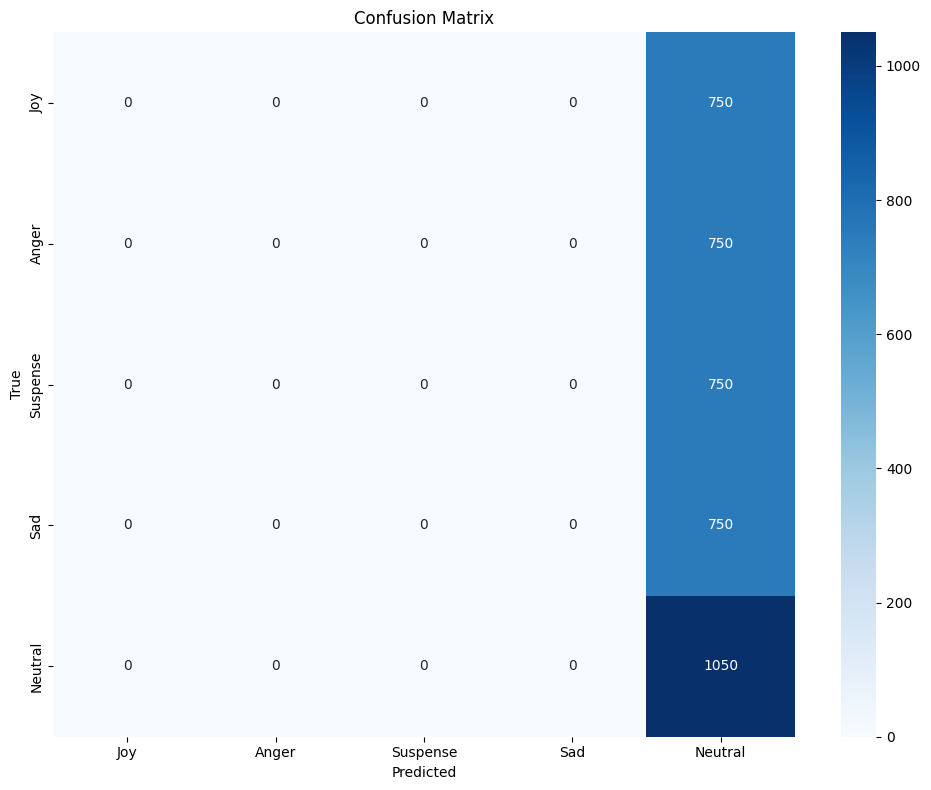

In [ ]:
import argparse
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import get_linear_schedule_with_warmup
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize argument parser
parser = argparse.ArgumentParser(description="Fine-tune for Bhaav 5-Emotion Classification")
parser.add_argument("--embeddings_path", type=str, default="indicbert_embeddings_resampled.npy")
parser.add_argument("--data_path", type=str, default="tokenized_dataset_resampled.csv")
parser.add_argument("--output_dir", type=str, default="bhaav_emotion_model")
parser.add_argument("--batch_size", type=int, default=32)
parser.add_argument("--learning_rate", type=float, default=3e-5)
parser.add_argument("--weight_decay", type=float, default=0.01)
parser.add_argument("--num_epochs", type=int, default=5)
parser.add_argument("--warmup_ratio", type=float, default=0.1)
parser.add_argument("--seed", type=int, default=42)
parser.add_argument("--use_wandb", action="store_true", help="Enable Weights & Biases logging")
parser.add_argument("--fp16", action="store_true", help="Use mixed precision training")
args, unknown = parser.parse_known_args()


# Set seed for reproducibility
torch.manual_seed(args.seed)
np.random.seed(args.seed)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define emotion mapping
EMOTION_LABELS = {
    0: "Joy",
    1: "Anger",
    2: "Suspense",
    3: "Sad",
    4: "Neutral"
}

# Initialize W&B if enabled
if args.use_wandb:
    wandb.init(
        project="bhaav-emotion-analysis",
        config={
            "emotions": list(EMOTION_LABELS.values()),
            "batch_size": args.batch_size,
            "learning_rate": args.learning_rate,
            "weight_decay": args.weight_decay,
            "epochs": args.num_epochs,
            "warmup_ratio": args.warmup_ratio,
        }
    )

# Load preprocessed data and embeddings
print("Loading preprocessed data and embeddings...")
data = pd.read_csv(args.data_path)
embeddings = np.load(args.embeddings_path)

print(f"Data shape: {data.shape}")
print(f"Embeddings shape: {embeddings.shape}")
print("Emotion distribution:")
emotion_counts = data['Annotation'].value_counts().sort_index()
for emotion_id, count in emotion_counts.items():
    print(f"  {EMOTION_LABELS[emotion_id]}: {count}")

# Split data into train/val/test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    embeddings,
    data['Annotation'].values,
    test_size=0.15,
    random_state=args.seed,
    stratify=data['Annotation'].values
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.15,
    random_state=args.seed,
    stratify=y_train_val
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Create PyTorch datasets
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size)

# Define a model that uses pre-computed embeddings
class EmotionClassifier(torch.nn.Module):
    def __init__(self, input_dim, num_classes=5):
        super(EmotionClassifier, self).__init__()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

# Initialize model
input_dim = embeddings.shape[1]  # Dimension of the embeddings
model = EmotionClassifier(input_dim).to(device)

# Set up optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
total_steps = len(train_loader) * args.num_epochs
warmup_steps = int(total_steps * args.warmup_ratio)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Set up mixed precision training if enabled
if args.fp16 and torch.cuda.is_available():
    scaler = torch.cuda.amp.GradScaler()
    print("Using mixed precision training (FP16)")
else:
    scaler = None
    if args.fp16:
        print("FP16 requested but not available, using FP32 instead")
    else:
        print("Using FP32 precision")

# Training loop
best_val_f1 = 0
print("Starting training...")

for epoch in range(args.num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_preds = []
    train_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{args.num_epochs} [Train]")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Backward pass with scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

        scheduler.step()

        # Collect statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({"loss": loss.item()})

    # Calculate training metrics
    train_acc = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{args.num_epochs} [Val]")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Collect statistics
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix({"loss": loss.item()})

    # Calculate validation metrics
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    val_loss = val_loss / len(val_loader)

    # Per-class F1 scores
    per_class_f1 = f1_score(val_labels, val_preds, average=None)
    emotion_f1 = {EMOTION_LABELS[i]: f1 for i, f1 in enumerate(per_class_f1)}

    # Print epoch results
    print(f"Epoch {epoch+1}/{args.num_epochs}:")
    print(f"  Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1: {val_f1:.4f}")
    print("  F1 scores per emotion:")
    for emotion, f1 in emotion_f1.items():
        print(f"    {emotion}: {f1:.4f}")

    # Log to W&B if enabled
    if args.use_wandb:
        log_dict = {
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "train_f1": train_f1,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "val_f1": val_f1,
        }
        # Add per-emotion F1 scores
        for emotion, f1 in emotion_f1.items():
            log_dict[f"val_f1_{emotion}"] = f1

        wandb.log(log_dict)

    # Save the best model
# Save the best model
# Save the best model
import os

# Ensure output directory exists
output_dir = "bhaav_emotion_model"
os.makedirs(output_dir, exist_ok=True)

if val_f1 > best_val_f1:
    best_val_f1 = val_f1
    best_model_path = os.path.join(args.output_dir, "best_model.pt")

    torch.save(model.state_dict(), best_model_path)
    print(f"  New best model saved with F1: {val_f1:.4f}")

# Load the best model for evaluation
best_model_path = os.path.join(args.output_dir, "best_model.pt")
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Test evaluation
test_preds = []
test_labels = []
test_probs = []


with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probabilities.cpu().numpy())

# Calculate test metrics
test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
per_class_f1 = f1_score(test_labels, test_preds, average=None)
emotion_f1 = {EMOTION_LABELS[i]: f1 for i, f1 in enumerate(per_class_f1)}

print("\nTest Results:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Weighted F1 Score: {test_f1:.4f}")
print("\nF1 Scores per Emotion:")
for emotion, f1 in emotion_f1.items():
    print(f"  {emotion}: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_preds,
                           target_names=[EMOTION_LABELS[i] for i in range(5)]))

# Create and save confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[EMOTION_LABELS[i] for i in range(5)],
            yticklabels=[EMOTION_LABELS[i] for i in range(5)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig(f"{args.output_dir}/confusion_matrix.png")
print(f"Confusion matrix saved to {args.output_dir}/confusion_matrix.png")

# Log final metrics to W&B
if args.use_wandb:
    log_dict = {
        "test_accuracy": test_acc,
        "test_f1": test_f1,
    }
    # Add per-emotion F1 scores
    for emotion, f1 in emotion_f1.items():
        log_dict[f"test_f1_{emotion}"] = f1

    # Log confusion matrix
    wandb.log(log_dict)
    wandb.log({"confusion_matrix": wandb.Image(f"{args.output_dir}/confusion_matrix.png")})
    wandb.finish()

# Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'num_classes': 5,
    'input_dim': input_dim,
    'emotion_labels': EMOTION_LABELS,
}, f"{args.output_dir}/final_model.pt")

print("Training and evaluation complete!")

# Create a class for inference
class BhaavEmotionPredictor:
    def __init__(self, model_path, device='cpu'):
        # Load model
        checkpoint = torch.load(model_path, map_location=device)
        self.input_dim = checkpoint['input_dim']
        self.num_classes = checkpoint['num_classes']
        self.emotion_labels = checkpoint['emotion_labels']

        # Initialize model
        self.model = EmotionClassifier(self.input_dim, self.num_classes).to(device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        self.device = device

    def predict(self, embedding):
        """
        Predict emotion from precomputed embedding
        """
        with torch.no_grad():
            tensor_input = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0).to(self.device)
            outputs = self.model(tensor_input)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
            prediction = torch.argmax(outputs, dim=1).item()

        result = {
            'emotion': self.emotion_labels[prediction],
            'emotion_id': prediction,
            'confidence': probabilities[prediction].item(),
            'probabilities': {self.emotion_labels[i]: prob.item() for i, prob in enumerate(probabilities)}
        }

        return result

# Example usage of the predictor
print("\nCreate an emotion predictor with:")
print("predictor = BhaavEmotionPredictor(model_path='{args.output_dir}/final_model.pt')")
print("result = predictor.predict(embedding)")

In [ ]:
!ls


'Bhaav-Dataset(1).xlsx'        indicbert_embeddings_resampled.npy   tokenized_dataset_resampled.csv
 bhaav_resampled_dataset.csv   sample_data
